In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
import xgboost as xgb

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber

import random
import os

In [2]:
DATA_PATH = "../data_backend/cleaned_data3.parquet"
TARGET_COL = "ffb_1%_oer"

FORECAST_HORIZON = 14
LOOKBACK = 90

# LSTM training
LSTM_EPOCHS = 50
LSTM_BATCH = 16
LSTM_PATIENCE = 15
SEED = 42

# XGBoost params
XGB_PARAMS = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.3,
    "seed": SEED,
}
XGB_NUM_ROUND = 1000
XGB_EARLY_STOP = 50

# reproducibility seeds
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
df = pd.read_parquet(DATA_PATH)

raw_features = ["import", "export", "production", "end_stock",
                "cpo_futures", "usd_myr_rate", "brent_oil_futures",
                "soybean_futures", "precipitation", "avg_temperature", "avg_humidity"]

engineered_features = ["lag_1","lag_3","lag_7","rolling_mean_7",
                       "rolling_mean_30","rolling_std_7","rolling_std_30",
                       "pct_change_1","pct_change_7"]

all_features = raw_features + engineered_features

X = df[all_features].values
y = df[TARGET_COL].values.reshape(-1, 1)

# Train / Val / Test split (by time)
N = len(df)
train_size = int(N * 0.7)
val_size = int(N * 0.2)
test_size = N - train_size - val_size

X_train_raw = X[:train_size]
X_val_raw   = X[train_size:train_size + val_size]
X_test_raw  = X[train_size + val_size:]

y_train_raw = y[:train_size]
y_val_raw   = y[train_size:train_size + val_size]
y_test_raw  = y[train_size + val_size:]

# Scale features/target
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train_raw)
X_val   = scaler_x.transform(X_val_raw)
X_test  = scaler_x.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

In [4]:
def create_multi_step_sequences(X, y, lookback, horizon):
    Xs, ys = [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i - lookback:i])
        ys.append(y[i:i + horizon].ravel())
    return np.array(Xs), np.array(ys)

X_train_lstm, y_train_lstm = create_multi_step_sequences(X_train, y_train, LOOKBACK, FORECAST_HORIZON)
X_val_lstm, y_val_lstm     = create_multi_step_sequences(X_val, y_val, LOOKBACK, FORECAST_HORIZON)
X_test_lstm, y_test_lstm   = create_multi_step_sequences(X_test, y_test, LOOKBACK, FORECAST_HORIZON)

print("LSTM sequence shapes:")
print("X_train_lstm:", X_train_lstm.shape, "y_train_lstm:", y_train_lstm.shape)
print("X_val_lstm:  ", X_val_lstm.shape,   "y_val_lstm:  ", y_val_lstm.shape)
print("X_test_lstm: ", X_test_lstm.shape,  "y_test_lstm: ", y_test_lstm.shape)

LSTM sequence shapes:
X_train_lstm: (1571, 90, 20) y_train_lstm: (1571, 14)
X_val_lstm:   (375, 90, 20) y_val_lstm:   (375, 14)
X_test_lstm:  (137, 90, 20) y_test_lstm:  (137, 14)


In [5]:
K.clear_session()

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, X_train.shape[1])),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(32),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(FORECAST_HORIZON)
])

lstm_model.compile(optimizer="adam", loss=Huber())

early_stop = EarlyStopping(monitor='val_loss', patience=LSTM_PATIENCE, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH,
    callbacks=[early_stop],
    verbose=1
)

# Predictions from LSTM (scaled space)
y_pred_train_lstm = lstm_model.predict(X_train_lstm)
y_pred_val_lstm   = lstm_model.predict(X_val_lstm)
y_pred_test_lstm  = lstm_model.predict(X_test_lstm)


Epoch 1/50


c:\Users\User\Desktop\test2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0587 - val_loss: 0.0156
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0106 - val_loss: 0.0062
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0044 - val_loss: 6.1359e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0041 - val_loss: 5.9499e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0034 - val_loss: 7.6368e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0031 - val_loss: 7.2412e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0027 - val_loss: 8.0242e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0024 - val_loss: 7.9465e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/ste

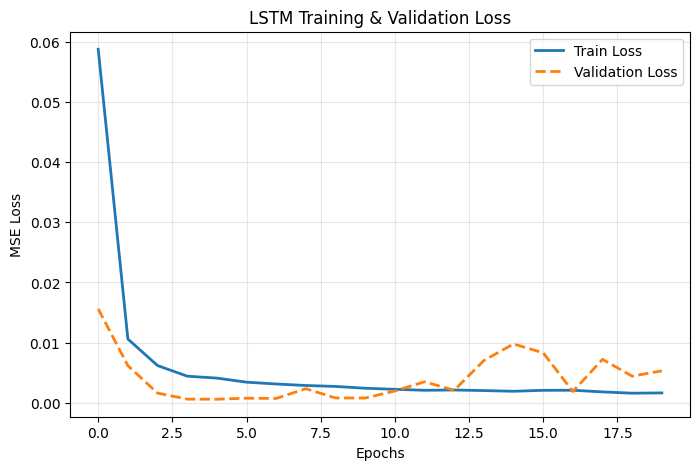

In [6]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="Train Loss", linewidth=2)
plt.plot(history.history['val_loss'], label="Validation Loss", linewidth=2, linestyle='--')
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [7]:
def inv_y(mat_scaled, scaler):
    # mat_scaled shape = (n_samples, horizon)
    flat = mat_scaled.reshape(-1, 1)
    inv_flat = scaler.inverse_transform(flat)
    return inv_flat.reshape(mat_scaled.shape)

y_pred_train_lstm_inv = inv_y(y_pred_train_lstm, scaler_y)
y_pred_val_lstm_inv   = inv_y(y_pred_val_lstm, scaler_y)
y_pred_test_lstm_inv  = inv_y(y_pred_test_lstm, scaler_y)

y_train_lstm_inv = inv_y(y_train_lstm, scaler_y)
y_val_lstm_inv   = inv_y(y_val_lstm, scaler_y)
y_test_lstm_inv  = inv_y(y_test_lstm, scaler_y)

# Baseline LSTM evaluation (flattened)
def metrics(y_true, y_pred, prefix=""):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    return rmse, mae, r2

print("\nBaseline LSTM (on test):")
lstm_rmse, lstm_mae, lstm_r2 = metrics(y_test_lstm_inv.flatten(), y_pred_test_lstm_inv.flatten(), prefix="LSTM")


Baseline LSTM (on test):
LSTM RMSE: 5.6966 | MAE: 4.9870 | R2: -0.9471


In [8]:
n_train_seq = y_pred_train_lstm_inv.shape[0]
n_val_seq   = y_pred_val_lstm_inv.shape[0]
n_test_seq  = y_pred_test_lstm_inv.shape[0]

X_train_tail = X_train[LOOKBACK: LOOKBACK + n_train_seq]   # shape: (n_train_seq, n_features)
X_val_tail   = X_val[LOOKBACK: LOOKBACK + n_val_seq]
X_test_tail  = X_test[LOOKBACK: LOOKBACK + n_test_seq]

# Augment features: concat LSTM multi-step preds (horizon columns) + the raw/engineered features at forecast time
X_train_xgb_aug = np.hstack([y_pred_train_lstm_inv, X_train_tail])
X_val_xgb_aug   = np.hstack([y_pred_val_lstm_inv,   X_val_tail])
X_test_xgb_aug  = np.hstack([y_pred_test_lstm_inv,  X_test_tail])

print("\nXGBoost augmented input shapes:")
print("X_train_xgb_aug:", X_train_xgb_aug.shape)
print("X_val_xgb_aug:  ", X_val_xgb_aug.shape)
print("X_test_xgb_aug: ", X_test_xgb_aug.shape)



XGBoost augmented input shapes:
X_train_xgb_aug: (1571, 34)
X_val_xgb_aug:   (375, 34)
X_test_xgb_aug:  (137, 34)


In [9]:
train_residuals = y_train_lstm_inv - y_pred_train_lstm_inv   # shape: (n_train_seq, horizon)
val_residuals   = y_val_lstm_inv - y_pred_val_lstm_inv

In [10]:
xgb_models = []
y_preds_residuals_test = []

for step in range(FORECAST_HORIZON):
    y_train_step = train_residuals[:, step]
    y_val_step   = val_residuals[:, step]

    dtrain = xgb.DMatrix(X_train_xgb_aug, label=y_train_step)
    dval   = xgb.DMatrix(X_val_xgb_aug, label=y_val_step)
    dtest  = xgb.DMatrix(X_test_xgb_aug)

    evallist = [(dtrain, 'train'), (dval, 'val')]

    model_step = xgb.train(
        XGB_PARAMS,
        dtrain,
        num_boost_round=XGB_NUM_ROUND,
        evals=evallist,
        early_stopping_rounds=XGB_EARLY_STOP,
        verbose_eval=False
    )

    xgb_models.append(model_step)
    pred_res_test_step = model_step.predict(dtest)
    y_preds_residuals_test.append(pred_res_test_step)

# Stack residual predictions into (n_test_seq, horizon)
y_pred_residuals_test = np.column_stack(y_preds_residuals_test)

In [11]:
y_pred_final_inv = y_pred_test_lstm_inv + y_pred_residuals_test

In [12]:
print("\nSequential Feature-Augmented Hybrid (LSTM + XGB residual correction) - Test performance:")
hybrid_rmse, hybrid_mae, hybrid_r2 = metrics(y_test_lstm_inv.flatten(), y_pred_final_inv.flatten(), prefix="Hybrid")

# Per-horizon RMSE comparison
print("\nPer-horizon RMSE (LSTM vs Hybrid):")
for h in range(FORECAST_HORIZON):
    rmse_l = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_test_lstm_inv[:, h])
    rmse_h = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_final_inv[:, h])
    r2_h = r2_score(y_test_lstm_inv[:, h], y_pred_final_inv[:, h])
    print(f"H{h+1:02d}: LSTM RMSE = {rmse_l:.4f} | Hybrid RMSE = {rmse_h:.4f} | Hybrid R2 = {r2_h:.4f} | Δ = {rmse_h - rmse_l:+.4f}")




Sequential Feature-Augmented Hybrid (LSTM + XGB residual correction) - Test performance:
Hybrid RMSE: 4.1911 | MAE: 2.9492 | R2: -0.0540

Per-horizon RMSE (LSTM vs Hybrid):
H01: LSTM RMSE = 5.1186 | Hybrid RMSE = 1.1271 | Hybrid R2 = 0.9207 | Δ = -3.9915
H02: LSTM RMSE = 3.6459 | Hybrid RMSE = 1.1855 | Hybrid R2 = 0.9129 | Δ = -2.4605
H03: LSTM RMSE = 4.5248 | Hybrid RMSE = 1.4692 | Hybrid R2 = 0.8664 | Δ = -3.0556
H04: LSTM RMSE = 4.8857 | Hybrid RMSE = 1.9631 | Hybrid R2 = 0.7614 | Δ = -2.9226
H05: LSTM RMSE = 7.7562 | Hybrid RMSE = 2.5767 | Hybrid R2 = 0.5891 | Δ = -5.1795
H06: LSTM RMSE = 4.0012 | Hybrid RMSE = 2.3040 | Hybrid R2 = 0.6723 | Δ = -1.6973
H07: LSTM RMSE = 6.7497 | Hybrid RMSE = 2.5833 | Hybrid R2 = 0.5913 | Δ = -4.1665
H08: LSTM RMSE = 4.4521 | Hybrid RMSE = 3.0491 | Hybrid R2 = 0.4331 | Δ = -1.4030
H09: LSTM RMSE = 6.7884 | Hybrid RMSE = 3.1048 | Hybrid R2 = 0.4178 | Δ = -3.6836
H10: LSTM RMSE = 5.5803 | Hybrid RMSE = 3.9289 | Hybrid R2 = 0.0813 | Δ = -1.6514
H11: L

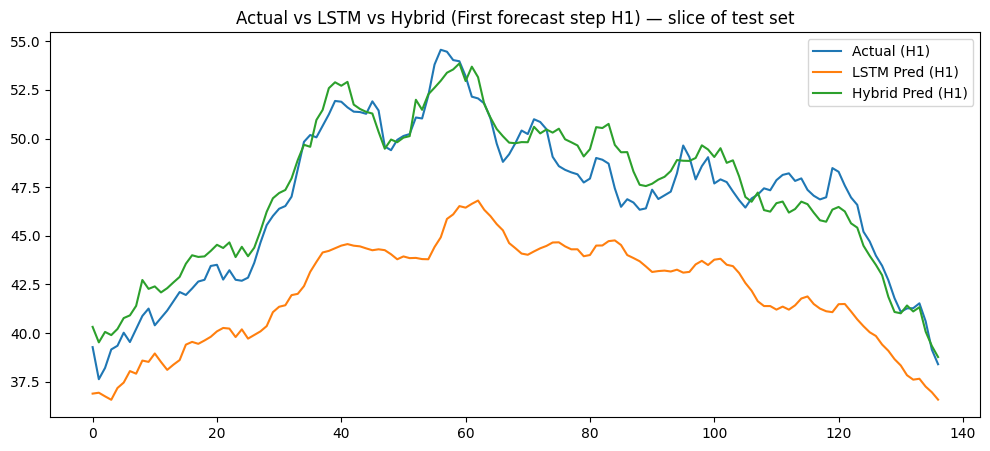

In [13]:
plt.figure(figsize=(12,5))
n_plot = min(230, y_test_lstm_inv.shape[0])  # plot first up to 200 samples (flattened horizon)
plt.plot(y_test_lstm_inv[:n_plot, 0].flatten(), label="Actual (H1)")
plt.plot(y_pred_test_lstm_inv[:n_plot, 0].flatten(), label="LSTM Pred (H1)")
plt.plot(y_pred_final_inv[:n_plot, 0].flatten(), label="Hybrid Pred (H1)")
plt.title("Actual vs LSTM vs Hybrid (First forecast step H1) — slice of test set")
plt.legend()
plt.show()

In [14]:
latest_actual = y_test_lstm_inv[-1, 0]
latest_forecast = y_pred_final_inv[-1, :] 


ffb = df['ffb_1%_oer']
returns = ffb.pct_change().dropna() * 100
volatility = (np.std(latest_forecast) / np.mean(latest_forecast)) * 100


def recommendation_engine2(
    current_price, 
    forecast, 
    volatility, 
    returns,
    model_rmse=None, 
    k=0.8
):
    """
    Enhanced recommendation engine combining volatility, forecast trend,
    and model uncertainty to give adaptive buy/sell/hold advice.
    """

    # --- STEP 1: Basic stats ---
    short_term = np.mean(forecast[:3])
    long_term  = np.mean(forecast[7:14])
    avg_forecast = np.mean(forecast)

    short_change = (short_term - current_price) / current_price * 100
    long_change  = (long_term - current_price) / current_price * 100
    overall_change = (avg_forecast - current_price) / current_price * 100

    # --- STEP 2: Forecast trend strength (slope of 14-day forecast) ---
    slope = np.polyfit(range(len(forecast)), forecast, 1)[0]
    trend_strength = slope / current_price * 100  # normalize to percentage

    # --- STEP 3: Estimate model uncertainty & confidence ---
    if model_rmse is None:
        model_rmse = 2.0  # default fallback
    uncertainty = model_rmse * (volatility / 10)
    confidence = np.clip(100 - uncertainty, 0, 100)
    
    # --- STEP 4: Detect market regime ---
    avg_daily_change = returns.mean()
    #recent_vol = volatility
    base_vol = returns.std()

    if volatility > base_vol * 1.3:
        regime = "High Volatility"
        k *= 1.2
    elif avg_daily_change > 0.3:
        regime = "Uptrend"
    elif avg_daily_change < -0.3:
        regime = "Downtrend"
    else:
        regime = "Stable"

    threshold = k * volatility


    # --- STEP 5: Decision logic (simplified and balanced) ---
    # Combine both forecast direction and threshold sensitivity
    if long_change > threshold * 0.8 and trend_strength > 0:
        action = "HOLD FIRST — Uptrend expected"
    elif long_change < -threshold * 0.8 and trend_strength < 0:
        action = "SELL NOW — Downtrend expected"
    elif abs(overall_change) <= threshold:
        action = "INDIFFERENCE — Stable market"
    else:
        action = "WAIT — Unclear"


    # --- STEP 6: Construct readable output ---
    recommendation = {
        "short_term_change(%)": round(short_change, 2),
        "long_term_change(%)": round(long_change, 2),
        "overall_change(%)": round(overall_change, 2),
        "trend_strength(%)": round(trend_strength, 2),
        "volatility(%)": round(volatility, 2),
        "uncertainty(%)": round(uncertainty, 2),
        "confidence(%)": round(confidence, 2),
        "market_regime": regime,
        "threshold(%)": round(threshold, 2),
        "recommendation": action
    }

    return recommendation

In [15]:
current_price = y_test_lstm_inv[-1, 0]
forecast = y_pred_final_inv[-1]

recommendation = recommendation_engine2(
    current_price=current_price,
    forecast=forecast,
    volatility=volatility,
    returns=returns
)

print("\n=== Final Forecast and Recommendation ===")
for k, v in recommendation.items():
    print(f"{k}: {v}")




=== Final Forecast and Recommendation ===
short_term_change(%): 1.2
long_term_change(%): 6.96
overall_change(%): 3.38
trend_strength(%): 0.93
volatility(%): 5.800000190734863
uncertainty(%): 1.159999966621399
confidence(%): 98.83999633789062
market_regime: High Volatility
threshold(%): 5.570000171661377
recommendation: HOLD FIRST — Uptrend expected


In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 1: Define actual labels (ground truth) ===
ffb = df['ffb_1%_oer']
actual_returns = ffb.pct_change().dropna() * 100

def get_actual_label(change, threshold=0.7):
    """
    Converts actual price change into categorical class.
    threshold: percentage change cutoff for defining HOLD/SEL/INDIFFERENT.
    """
    if change > threshold:
        return "HOLD FIRST"
    elif change < -threshold:
        return "SELL NOW"
    else:
        return "INDIFFERENT"

actual_labels = actual_returns.apply(get_actual_label)

# === STEP 2: Generate model predictions ===
predicted_labels = []

for i in range(len(y_pred_final_inv)):
    current_price = y_test_lstm_inv[i, 0]
    forecast = y_pred_final_inv[i, :]  # next 14-day forecast
    volatility = np.std(forecast) / np.mean(forecast) * 100

    rec = recommendation_engine2(
        current_price=current_price,
        forecast=forecast,
        volatility=volatility,
        returns=actual_returns
    )

    # Extract the action (e.g., "BUY" from "BUY — Uptrend forming")
    predicted_action = rec["recommendation"].split("—")[0].strip()
    predicted_labels.append(predicted_action)

# === STEP 3: Align actual vs predicted lengths ===
min_len = min(len(predicted_labels), len(actual_labels))
y_true = list(actual_labels[-min_len:])
y_pred = predicted_labels[-min_len:]

# === STEP 4: Normalize recommendations ===
valid_classes = {"HOLD FIRST", "SELL NOW", "INDIFFERENT"}

y_true = [t if t in valid_classes else "INDIFFERENT" for t in y_true]
y_pred = [p if p in valid_classes else "INDIFFERENT" for p in y_pred]

# === STEP 5: Compute metrics ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("=== Recommendation System Performance (HOLD/SELL/NEUTRAL) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Detailed per-class metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

=== Recommendation System Performance (HOLD/SELL/NEUTRAL) ===
Accuracy : 0.2336
Precision: 0.2210
Recall   : 0.2276
F1-score : 0.2072

Classification Report:
              precision    recall  f1-score   support

  HOLD FIRST       0.19      0.33      0.25        42
 INDIFFERENT       0.30      0.30      0.30        53
    SELL NOW       0.17      0.05      0.07        42

    accuracy                           0.23       137
   macro avg       0.22      0.23      0.21       137
weighted avg       0.23      0.23      0.21       137




Confusion Matrix:
                    Pred HOLD  Pred SELL  Pred INDIFFERENT
Actual HOLD                14          2                26
Actual SELL                29          2                11
Actual INDIFFERENT         29          8                16


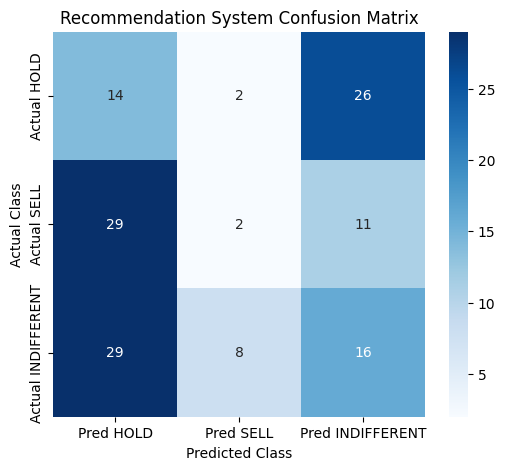

In [17]:
# === STEP 6: Confusion Matrix (3x3) ===
cm = confusion_matrix(y_true, y_pred, labels=["HOLD FIRST", "SELL NOW", "INDIFFERENT"])

cm_df = pd.DataFrame(
    cm,
    index=["Actual HOLD", "Actual SELL", "Actual INDIFFERENT"],
    columns=["Pred HOLD", "Pred SELL", "Pred INDIFFERENT"]
)

print("\nConfusion Matrix:")
print(cm_df)

# === STEP 7: Visualization ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Recommendation System Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()